In [ ]:
#correct benchmark model

In [1]:
import pandas as pd
import numpy as np
# Load local .csv file as DataFrame
df = pd.read_csv('duk_merge.csv')
# Inspect the data
df = df[:12000]

df['Date'] = df['Datetime'].str[:-6]
df['Date']=pd.to_datetime(df["Date"]).dt.strftime("%Y-%m-%d %H:%M:%S")

data_date = df.filter(['Date'])

data_date = data_date.values
# Get the number of rows to train the model on
training_data_date = int(np.ceil( len(data_date) * .95 ))

from sklearn.preprocessing import MinMaxScaler

#scaler1 = MinMaxScaler(feature_range=(0,1))
#scaled_data1 = scaler1.fit_transform(data_date)
# Create the training data set 
# Create the scaled training data set
train_data_date = data_date[0:int(training_data_date), :]

# Create a new dataframe with only the 'Close column 
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

In [2]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(5, len(train_data)):
    x_train.append(train_data[i-5:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 6:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
#x_train = np.reshape(x_train, ( x_train.shape[0], x_train.shape[1], 1))

[array([0.8928294 , 0.8928294 , 0.89795971, 0.90195009, 0.9022354 ])]
[0.9053707294202802]

[array([0.8928294 , 0.8928294 , 0.89795971, 0.90195009, 0.9022354 ]), array([0.8928294 , 0.89795971, 0.90195009, 0.9022354 , 0.90537073])]
[0.9053707294202802, 0.9059404734877647]



In [3]:
n_steps = 1
n_length = 5
n_features = 1
n_outputs=1


In [4]:
df.size

56032

In [5]:
x_train.shape

(6649, 5)

In [6]:
train_x = x_train.reshape((x_train.shape[0], n_steps, 1, n_length, n_features))
# reshape output into [samples, timesteps, features]
train_y = y_train.reshape((y_train.shape[0],1, 1))

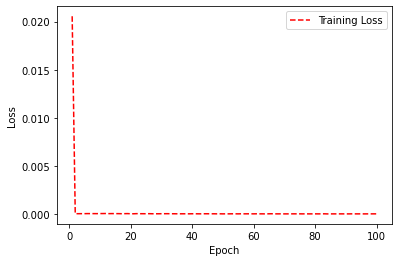

In [7]:
#cnn-lstm

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers import ConvLSTM2D
from keras.layers.convolutional import MaxPooling1D
from numpy import array
import matplotlib.pyplot as plt

# Build the LSTM model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, 1)))
model.add(Flatten())
model.add(RepeatVector(n_outputs))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer='adam')

# Train the model
history = model.fit(train_x, train_y, verbose=0, batch_size=16, epochs=100)

# Get training and test loss histories
training_loss = history.history['loss']
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [9]:
test_data = scaled_data[training_data_len - 5: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(5, len(test_data)):
    x_test.append(test_data[i-5:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], n_steps, 1, n_length, n_features ))

# Get the models predicted price values 
predictions3 = model.predict(x_test)
predictions3_3 = np.reshape(predictions3,(predictions3.shape[0],1))
predictions34 = scaler.inverse_transform(predictions3_3)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions34 - y_test) ** 2)))
rmse

0.12330570860253158

In [10]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100 

train = data[:training_data_len]
valid_c = data[training_data_len:]
valid_c['Predictions3'] = predictions34

mape(valid_c['Close'], valid_c['Predictions3'])

<ipython-input-10-1e3a86ec6641>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_c['Predictions3'] = predictions34


0.11297406986325302

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 3, 64)          50176     
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 1, 192)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 1, 200)            314400    
                                                                 
 time_distributed (TimeDistr  (None, 1, 100)           20100     
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 1, 1)             1